# Libraries

In [ ]:
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive and load the dataset
drive.mount('/content/drive')
data = pd.read_csv('{file_path}/copy_sentiment140.csv', encoding='latin1', header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Preprocessing

1.1. Assign Column Names

    Assign meaningful names to the columns for easier access and understanding.

In [ ]:
# Assign column names
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [ ]:
# Sample a fraction of the data, e.g., 10%
fraction = 0.01
data = data.sample(frac=fraction, random_state=42)

data.head()

,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


1.2. Text Cleaning

    Perform text cleaning operations such as removing punctuation, special characters, URLs, converting to lowercase, etc.

In [ ]:
import re
import string

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove usernames
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

data['clean_text'] = data['text'].apply(clean_text)
data.head()


,target,ids,date,flag,user,text,clean_text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next ti...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email wont open and i have geography s...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airways problem


1.3. Tokenization and Stop Words Removal

    Tokenize the tweets and remove common stop words.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure you have the necessary NLTK data files
import nltk
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {'im', 'rt', 'u'}  # Add any additional stop words here
stop_words.update(custom_stop_words)

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Assuming data has a column 'clean_text' with preprocessed text
data['tokens'] = data['clean_text'].apply(tokenize_and_remove_stopwords)
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,ids,date,flag,user,text,clean_text,tokens
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok,"[ahhh, hope, ok]"
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr,"[cool, tweet, apps, razr]"
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next ti...,"[know, family, drama, lamehey, next, time, han..."
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email wont open and i have geography s...,"[school, email, wont, open, geography, stuff, ..."
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airways problem,"[upper, airways, problem]"


1.4. Stemming or Lemmatization

    Choose between stemming and lemmatization to reduce words to their root form.

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# You can choose either stemming or lemmatization
data['stemmed_tokens'] = data['tokens'].apply(stem_tokens)
data['lemmatized_tokens'] = data['tokens'].apply(lemmatize_tokens)
data.head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,target,ids,date,flag,user,text,clean_text,tokens,stemmed_tokens,lemmatized_tokens
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh i hope your ok,"[ahhh, hope, ok]","[ahhh, hope, ok]","[ahhh, hope, ok]"
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",cool i have no tweet apps for my razr,"[cool, tweet, apps, razr]","[cool, tweet, app, razr]","[cool, tweet, apps, razr]"
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,i know just family drama its lamehey next ti...,"[know, family, drama, lamehey, next, time, han...","[know, famili, drama, lamehey, next, time, han...","[know, family, drama, lamehey, next, time, han..."
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email wont open and i have geography s...,"[school, email, wont, open, geography, stuff, ...","[school, email, wont, open, geographi, stuff, ...","[school, email, wont, open, geography, stuff, ..."
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airways problem,"[upper, airways, problem]","[upper, airway, problem]","[upper, airway, problem]"


# 2. Feature Engineering

2.1. Bag-of-Words Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Using stemmed tokens or lemmatized tokens as per your choice
vectorizer = CountVectorizer(analyzer=lambda x: x)
X_bow = vectorizer.fit_transform(data['lemmatized_tokens'])


2.2. TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized_tokens'])


## Distribution of Sentiments

<ipython-input-102-175b909d8a53>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette='viridis')


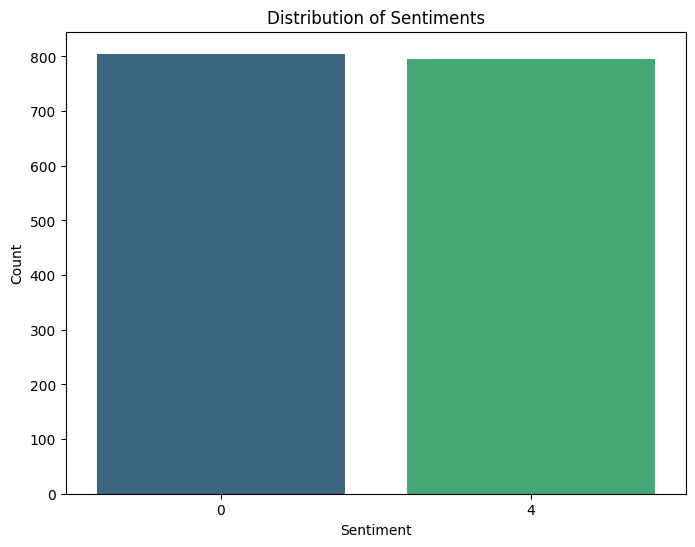

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Word Cloud for Each Sentiment

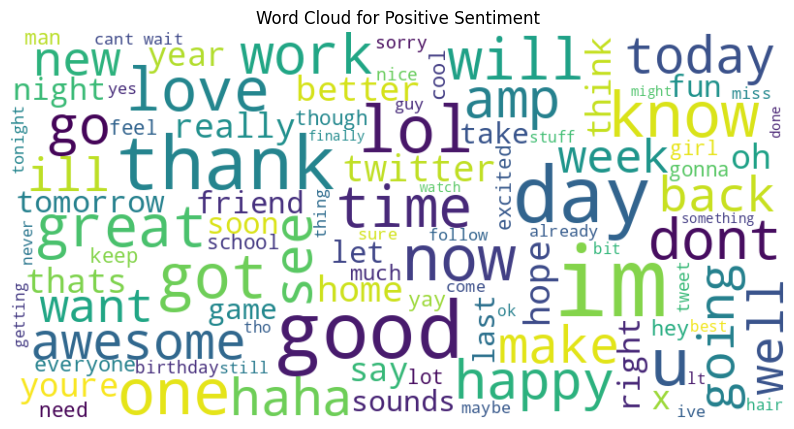

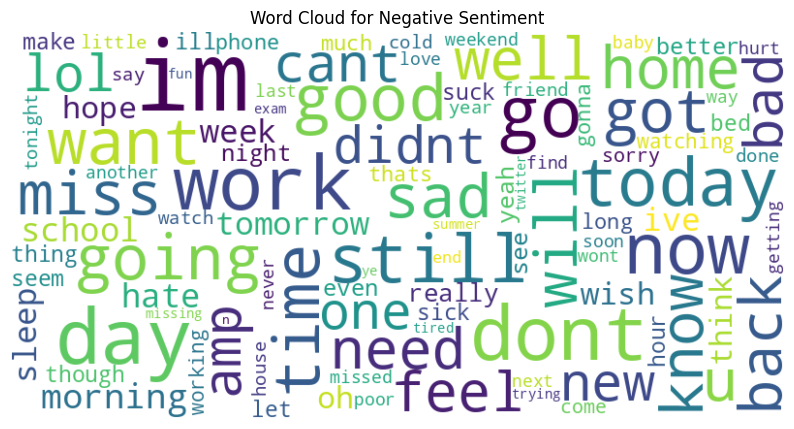

In [ ]:
from wordcloud import WordCloud

# Word Cloud for Positive Sentiment
positive_text = ' '.join(data[data['target'] == 4]['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# Word Cloud for Negative Sentiment
negative_text = ' '.join(data[data['target'] == 0]['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()


## Length Distribution of Tweets

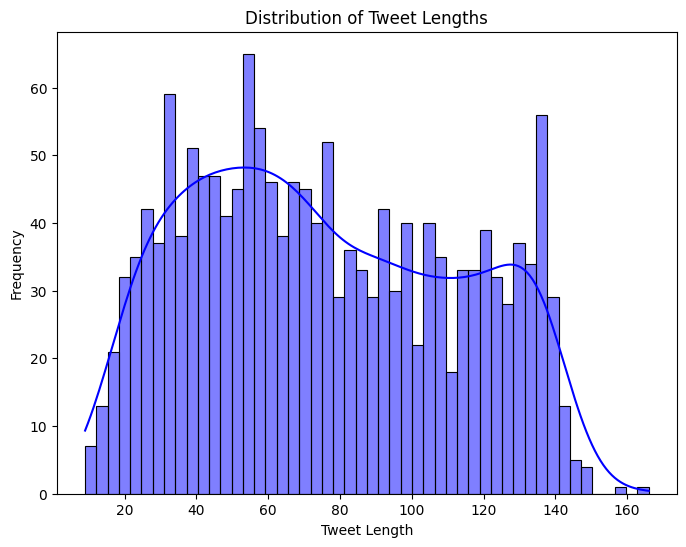

In [ ]:
# Length Distribution of Tweets
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


## Most Frequent Words in Each Sentiment Category

<ipython-input-105-185e68021ec9>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


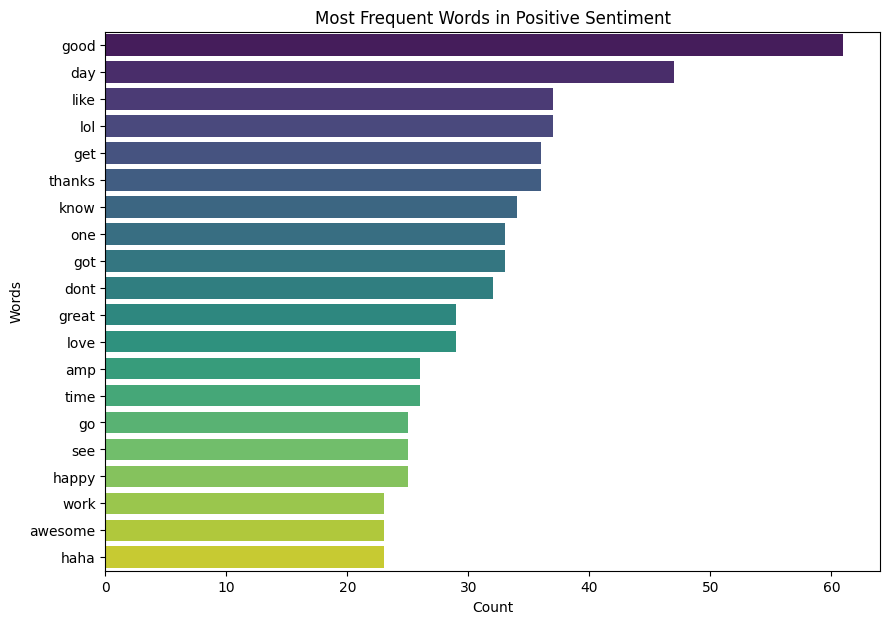

<ipython-input-105-185e68021ec9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


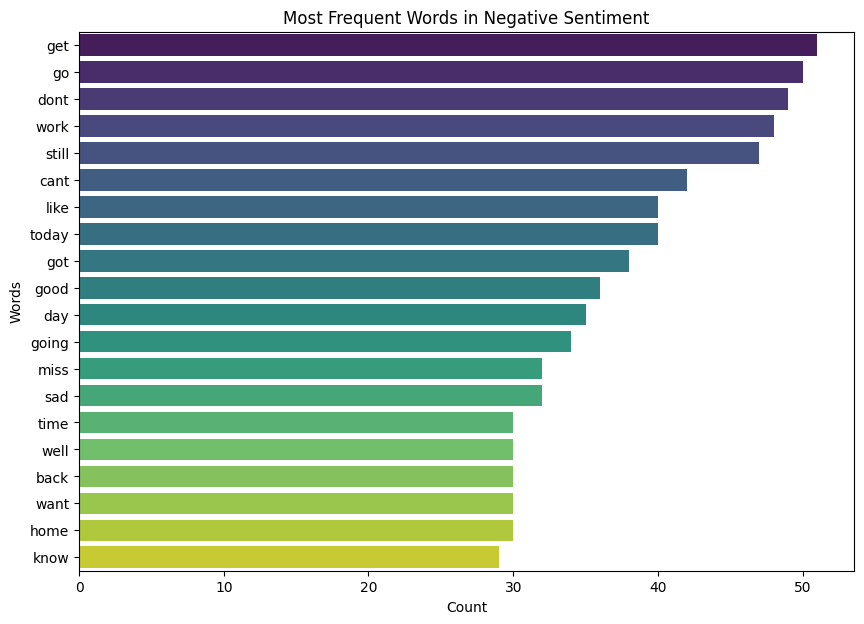

In [ ]:
from collections import Counter

# Function to get the most frequent words
def get_most_frequent_words(tokens, n=20):
    counter = Counter(tokens)
    most_common = counter.most_common(n)
    words, counts = zip(*most_common)
    return words, counts

# Most Frequent Words in Positive Sentiment
positive_tokens = [token for tokens in data[data['target'] == 4]['tokens'] for token in tokens]
words, counts = get_most_frequent_words(positive_tokens)
plt.figure(figsize=(10, 7))
sns.barplot(x=counts, y=words, palette='viridis')
plt.title('Most Frequent Words in Positive Sentiment')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

# Most Frequent Words in Negative Sentiment
negative_tokens = [token for tokens in data[data['target'] == 0]['tokens'] for token in tokens]
words, counts = get_most_frequent_words(negative_tokens)
plt.figure(figsize=(10, 7))
sns.barplot(x=counts, y=words, palette='viridis')
plt.title('Most Frequent Words in Negative Sentiment')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


# 3. Model Building

3.1. Splitting the Data

In [ ]:
from sklearn.model_selection import train_test_split

# Map the original labels to a new set of labels
label_mapping = {0: 0, 4: 1}
data_sampled = data[data['target'].isin(label_mapping.keys())]  # Filter out the neutral class (2)
data_sampled['target_mapped'] = data_sampled['target'].map(label_mapping)

# Use the mapped labels for train-test split
X = X_tfidf
y = data_sampled['target_mapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert labels to categorical one-hot encoding
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

3.2. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.65625
Confusion Matrix:
 [[110  55]
 [ 55 100]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       165
           1       0.65      0.65      0.65       155

    accuracy                           0.66       320
   macro avg       0.66      0.66      0.66       320
weighted avg       0.66      0.66      0.66       320



# 4. Model Selection

4.1. Support Vector Machine



In [ ]:
from sklearn.svm import SVC

# Train the SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.646875
SVM Confusion Matrix:
 [[104  61]
 [ 52 103]]
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65       165
           1       0.63      0.66      0.65       155

    accuracy                           0.65       320
   macro avg       0.65      0.65      0.65       320
weighted avg       0.65      0.65      0.65       320



4.2 Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.646875
Naive Bayes Confusion Matrix:
 [[117  48]
 [ 65  90]]
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.71      0.67       165
           1       0.65      0.58      0.61       155

    accuracy                           0.65       320
   macro avg       0.65      0.64      0.64       320
weighted avg       0.65      0.65      0.65       320



4.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.64375
Random Forest Confusion Matrix:
 [[ 88  77]
 [ 37 118]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.53      0.61       165
           1       0.61      0.76      0.67       155

    accuracy                           0.64       320
   macro avg       0.65      0.65      0.64       320
weighted avg       0.66      0.64      0.64       320



4.4 Neural Network (using Keras)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(2, activation='softmax'))  # 2 classes: negative, positive

# Compile the model
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train.toarray(), y_train_cat, epochs=10, batch_size=512, validation_split=0.1)

# Predict and evaluate
y_pred_nn = np.argmax(nn_model.predict(X_test.toarray()), axis=1)

# Reverse mapping for original labels
reverse_label_mapping = {0: 0, 1: 4}
y_test_original = y_test.map(reverse_label_mapping)
y_pred_nn_original = np.vectorize(reverse_label_mapping.get)(y_pred_nn)

print("Neural Network Accuracy:", accuracy_score(y_test_original, y_pred_nn_original))
print("Neural Network Confusion Matrix:\n", confusion_matrix(y_test_original, y_pred_nn_original))
print("Neural Network Classification Report:\n", classification_report(y_test_original, y_pred_nn_original))


Epoch 1/10
3/3 [==============================] - 2s 214ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6924 - val_accuracy: 0.5547
Epoch 2/10
3/3 [==============================] - 0s 92ms/step - loss: 0.6895 - accuracy: 0.5642 - val_loss: 0.6915 - val_accuracy: 0.5781
Epoch 3/10
3/3 [==============================] - 0s 107ms/step - loss: 0.6869 - accuracy: 0.5990 - val_loss: 0.6906 - val_accuracy: 0.5859
Epoch 4/10
3/3 [==============================] - 0s 115ms/step - loss: 0.6796 - accuracy: 0.6510 - val_loss: 0.6884 - val_accuracy: 0.5938
Epoch 5/10
3/3 [==============================] - 0s 109ms/step - loss: 0.6706 - accuracy: 0.6918 - val_loss: 0.6842 - val_accuracy: 0.6250
Epoch 6/10
3/3 [==============================] - 0s 99ms/step - loss: 0.6547 - accuracy: 0.7474 - val_loss: 0.6780 - val_accuracy: 0.6797
Epoch 7/10
3/3 [==============================] - 0s 88ms/step - loss: 0.6210 - accuracy: 0.8264 - val_loss: 0.6678 - val_accuracy: 0.6953
Epoch 8/10
3/3 [=======

#5. Combining Results and Choosing the Best Model

In [ ]:
def summarize_results(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"{name} Accuracy:", accuracy_score(y_test, y_pred))
        print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

# Store models in a dictionary
models = {
    'Logistic Regression': logreg,
    'SVM': svm_model,
    'Naive Bayes': nb_model,
    'Random Forest': rf_model
}

# Summarize results
summarize_results(models, X_test, y_test)


Logistic Regression Accuracy: 0.65625
Logistic Regression Confusion Matrix:
 [[110  55]
 [ 55 100]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       165
           1       0.65      0.65      0.65       155

    accuracy                           0.66       320
   macro avg       0.66      0.66      0.66       320
weighted avg       0.66      0.66      0.66       320

SVM Accuracy: 0.646875
SVM Confusion Matrix:
 [[104  61]
 [ 52 103]]
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65       165
           1       0.63      0.66      0.65       155

    accuracy                           0.65       320
   macro avg       0.65      0.65      0.65       320
weighted avg       0.65      0.65      0.65       320

Naive Bayes Accuracy: 0.646875
Naive Bayes Confusion Matrix:
 [[117  48]
 [ 65  90]]
Naive Bayes Classifi

In [ ]:
# Add neural network results separately
y_pred_nn = np.argmax(nn_model.predict(X_test.toarray()), axis=1)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Neural Network Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))


10/10 [==============================] - 0s 13ms/step
Neural Network Accuracy: 0.6375
Neural Network Confusion Matrix:
 [[105  60]
 [ 56  99]]
Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.64      0.64       165
           1       0.62      0.64      0.63       155

    accuracy                           0.64       320
   macro avg       0.64      0.64      0.64       320
weighted avg       0.64      0.64      0.64       320



## Model Performance Comparison

In [ ]:
print("Model Names:", model_names)
print("Accuracies:", accuracies)
print("Length of Model Names:", len(model_names))
print("Length of Accuracies:", len(accuracies))


Model Names: ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Neural Network']
Accuracies: [0.65625, 0.653125, 0.64375, 0.61875, 0.65625]
Length of Model Names: 5
Length of Accuracies: 5


<ipython-input-115-85d655bbf57a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


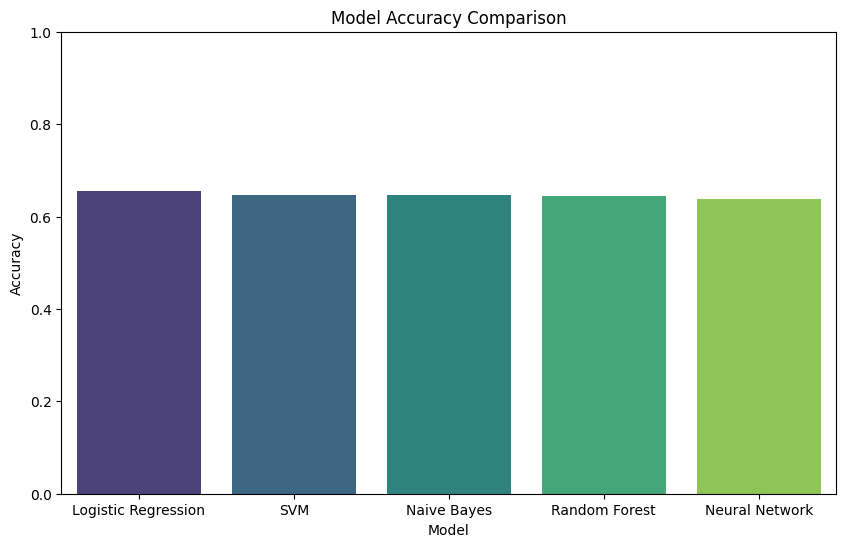

In [ ]:
# Model Performance Comparison
model_names = ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest', 'Neural Network']
accuracies = [accuracy_score(y_test, logreg.predict(X_test)),
              accuracy_score(y_test, svm_model.predict(X_test)),
              accuracy_score(y_test, nb_model.predict(X_test)),
              accuracy_score(y_test, rf_model.predict(X_test)),
              accuracy_score(y_test_original, y_pred_nn_original)]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## Confusion Matrix Heatmap

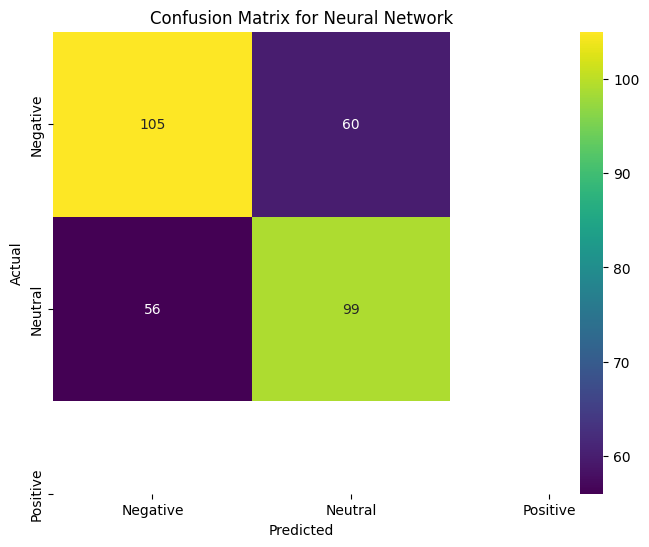

In [ ]:
# Confusion Matrix for Neural Network
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## ROC Curve for NN

10/10 [==============================] - 0s 16ms/step


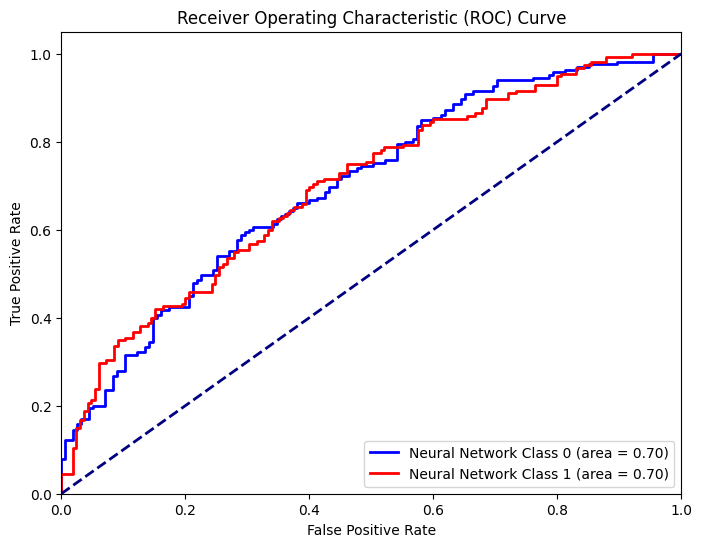

In [ ]:
# Compute ROC curve and ROC area for each class for Neural Network
fpr_nn = {}
tpr_nn = {}
roc_auc_nn = {}
for i in range(2):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(y_test_cat[:, i], nn_model.predict(X_test.toarray())[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red']
for i in range(2):
    plt.plot(fpr_nn[i], tpr_nn[i], color=colors[i], lw=2, label=f'Neural Network Class {i} (area = {roc_auc_nn[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()